## Ré-échantillonage

In [ ]:
import os
import argparse
import torch as th
import torch.nn.functional as F
import time
import conf_mgt
from utils import yamlread
from guided_diffusion import dist_util
from tqdm import tqdm
# Workaround
try:
    import ctypes
    libgcc_s = ctypes.CDLL('libgcc_s.so.1')
except:
    pass


from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    classifier_defaults,
    create_model_and_diffusion,
    create_classifier,
    select_args,
)  # noqa: E402

from guided_diffusion.script_util import (
    sr_model_and_diffusion_defaults,
    sr_create_model_and_diffusion,
)
def toU8(sample):
    if sample is None:
        return sample

    sample = ((sample + 1) * 127.5).clamp(0, 255).to(th.uint8)
    sample = sample.permute(0, 2, 3, 1)
    sample = sample.contiguous()
    sample = sample.detach().cpu().numpy()
    return sample

import torch
import torchvision.transforms as T

In [ ]:
intermediate_steps = False #return intermediate results (usefull to create gifs, but will use lot of memory - around 3GB for one 256x256 image)
conf = conf_mgt.conf_base.Default_Conf()
conf.update(yamlread('confs/my_conf-2.yml'))
print(conf.inpa_inj_sched_prev) #Are you about to use RePainting ?print(conf.diffusion_steps) #may not be the good one
conf.intermediate_steps = intermediate_steps
print(conf.intermediate_steps)


True
False


In [ ]:
print("Start", conf['name'])

device = dist_util.dev(conf.get('device'))


model, diffusion = create_model_and_diffusion(
    **select_args(conf, model_and_diffusion_defaults().keys()), conf=conf
)


Start my_conf


In [ ]:
model.load_state_dict(
    dist_util.load_state_dict(os.path.expanduser(
        conf.model_path), map_location="cpu")
)
model.to(device)
if conf.use_fp16:
    model.convert_to_fp16()
model.eval()

show_progress = conf.show_progress

import numpy as np
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Nombre de paramètres : ', params)

Nombre de paramètres :  552814086


In [ ]:
# https://colab.research.google.com/drive/12a_Wrfi2_gwwAuN3VvMTwVMz9TfqctNj#scrollTo=7zAqFEykBHDL TO DO

In [ ]:

cond_fn = None

def model_fn(x, t, y=None, gt=None, **kwargs):
    assert y is not None
    return model(x, t, y if conf.class_cond else None, gt=gt)

In [ ]:
dset = 'eval'

eval_name = conf.get_default_eval_name()

IMAGE_SIZE = 256
GT_PATH = './data/datasets/gts/face'
MASK_PATH = './data/datasets/gt_keep_masks/face'
dataconfig = {'mask_loader': True,
 'gt_path': GT_PATH,
 'mask_path': MASK_PATH,
 'image_size': IMAGE_SIZE,
 'class_cond': False,
 'deterministic': True, # Pas de shuffle dans le dataloader
 'random_crop': False, # Crop (au lieu de redimensionner l'image). Non Implémenté.
 'random_flip': False,
 'return_dict': True,
 'drop_last': False,
 'batch_size': 1,
 'return_dataloader': True,
 'offset': 0,
 'max_len': 8,
 'paths': {'srs': './log/face_example/inpainted',
  'lrs': './log/face_example/gt_masked',
  'gts': './log/face_example/gt',
  'gt_keep_masks': './log/face_example/gt_keep_mask'}
             }

conf['data']['eval'][eval_name] = dataconfig
dl = conf.get_dataloader(dset=dset, dsName=eval_name)
batch = next(iter(dl))

In [ ]:
img = batch['GT'].to(device)
mask = batch['gt_keep_mask'].to(device)

img = torch.stack([img[0],img[0]])
mask = torch.stack([mask[0],mask[0]])

model_kwargs = {}
model_kwargs["gt"] = img
model_kwargs['y'] = 'SALUT LOLOL' #Utile seulement si conf.cond_y (voir model_fn au dessus). Doit être défini.
model_kwargs['gt_keep_mask'] = mask
model_kwargs['stop_to'] = 4000
model_kwargs['starting_point'] = None
batch_size = model_kwargs['gt'].shape[0]

sample_fn = (
    diffusion.p_sample_loop if not conf.use_ddim else diffusion.ddim_sample_loop
)



  0%|          | 0/4570 [00:00<?, ?it/s]

In [ ]:
conf.intermediate_steps].save')

La configuration du dataset contient notamment les arguments utilisés par la classe ImageDatasetInpa (image_dataset.py dans le dossier guided_diffusion) pour retourner à partir du répertoire des images un dataset pytorch. Ce dataset est converti en dataloader avec la fonction DataLoader dans le même fichier.

Pour créer un dataset ImageDatasetInpa il faut la liste des imagages que l'on souhaite utiliser, et que l'on récupère avec la fonction _list_image_files_recursivcely.

In [ ]:
return_all = False
result = sample_fn(
    model_fn,
    (batch_size, 3, conf.image_size, conf.image_size),
    clip_denoised=conf.clip_denoised,
    model_kwargs=model_kwargs,
    cond_fn=cond_fn,
    device=device,
    progress=show_progress,
    return_all=return_all,
    conf=conf
)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
transform = T.ToPILImage()
def tou8batch(result,return_all=False):
    if return_all:
        finals = result[1]['sample']
    else:
        finals = result
    finals = ((finals + 1) * 127.5).clamp(0, 255).to(th.uint8)
    finals = finals.contiguous()
    return(finals)
y = tou8batch(result)

In [ ]:
transform(y[20][0])

In [ ]:
i=5
for sample in finals:
    img = transform(sample)
    img.save("images/sample_"+str(i)+".jpeg")
    i+=1

In [ ]:
model_kwargs['stop_to'] = None
model_kwargs['starting_point'] = {'x':result,'step':4000}

In [ ]:
return_all = False
result_bis = sample_fn(
    model_fn,
    (batch_size, 3, conf.image_size, conf.image_size),
    clip_denoised=conf.clip_denoised,
    model_kwargs=model_kwargs,
    cond_fn=cond_fn,
    device=device,
    progress=show_progress,
    return_all=return_all,
    conf=conf
)


  0%|          | 0/2572 [00:00<?, ?it/s]

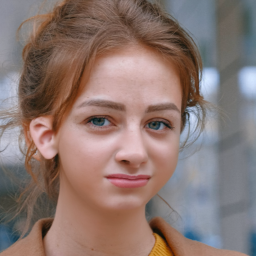

In [33]:
y = tou8batch(result_bis)
transform(y[1])

In [ ]:
del result
torch.cuda.empty_cache()
!nvidia-smi

Sat Dec 24 00:20:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   30C    P8    10W / 200W |   6381MiB /  8192MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------